<a href="https://colab.research.google.com/github/sid-chaubs/data-mining-assignment-1/blob/main/DMT_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading and formatting data

In [1]:
from google.colab import drive
drive.mount('/content/datadrive')

Mounted at /content/datadrive


In [2]:
!mkdir /content/training_data
!mkdir /content/test_data
!unzip -o /content/datadrive/MyDrive/training_set_VU_DM.csv.zip -d /content/training_data/
!unzip -o /content/datadrive/MyDrive/test_set_VU_DM.csv.zip -d /content/test_data/
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

Archive:  /content/datadrive/MyDrive/training_set_VU_DM.csv.zip
  inflating: /content/training_data/training_set_VU_DM.csv  
Archive:  /content/datadrive/MyDrive/test_set_VU_DM.csv.zip
  inflating: /content/test_data/test_set_VU_DM.csv  
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 394.7MB 43kB/s 
     |████████████████████████████████| 3.9MB 16.9MB/s 
     |████████████████████████████████| 11.1MB 11.0MB/s 


In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick import target, features
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

SEED = 1337 * 420 * 69
SAMPLE_SIZE = 5000

np.random.seed(SEED)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


|Column Name|Data Type|Description|
|-----------|---------|-----------|
|srch_id|Integer|The ID of the search|
|date_time|Date/time|Date and time of the search|
|site_id|Integer|ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ..)|
|visitor_location_country_id |Integer|The ID of the country the customer is located|
|visitor_hist_starrating |Float|The mean star rating of hotels the customer has previously purchased; null signifies there is no purchase history on the customer|
|visitor_hist_adr_usd|Float|The mean price per night (in US$) of the hotels the customer has previously purchased; null signifies there is no purchase history on the customer|
|prop_country_id|Integer|The ID of the country the hotel is located in|
|prop_id|Integer|The ID of the hotel|
|prop_starrating|Integer|The star rating of the hotel, from 1 to 5, in increments of 1.  A 0 indicates the property has no stars, the star rating is not known or cannot be publicized.|
|prop_review_score|Float|The mean customer review score for the hotel on a scale out of 5, rounded to 0.5 increments. A 0 means there have been no reviews, null that the information is not available.|
|prop_brand_bool|Integer|+1 if the hotel is part of a major hotel chain; 0 if it is an independent hotel|
|prop_location_score1|Float|A (first) score outlining the desirability of a hotel’s location|
|prop_location_score2|Float|A (second) score outlining the desirability of the hotel’s location|
|prop_log_historical_price position|Float   Integer|The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period. Hotel position on Expedia's search results page. This is only provided for the training data, but not the test data.|
|price_usd|Float|Displayed price of the hotel for the given search.  Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay|
|promotion_flag|Integer|+1 if the hotel had a sale price promotion specifically displayed|
|gross_booking_usd     srch_destination_id |Float     Integer|Total value of the transaction.  This can differ from the price_usd due to taxes, fees, conventions on multiple day bookings and purchase of a room type other than the one shown in the search ID of the destination where the hotel search was performed|
|srch_length_of_stay|Integer|Number of nights stay that was searched|
|srch_booking_window|Integer|Number of days in the future the hotel stay started from the search date|
|srch_adults_count|Integer|The number of adults specified in the hotel room|
|srch_children_count|Integer|The number of (extra occupancy) children specified in the hotel room|
|srch_room_count|Integer|Number of hotel rooms specified in the search|
|srch_saturday_night_bool|Boolean|+1 if the stay includes a Saturday night, starts from Thursday with a length of stay is less than or equal to 4 nights (i.e. weekend); otherwise 0|
|srch_query_affinity_score|Float|The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)|
|orig_destination_distance|Float|Physical distance between the hotel and the customer at the time of search. A null means the distance could not be calculated.|
|random_bool|Boolean|+1 when the displayed sort was random, 0 when the normal sort order was displayed|
| | | |
|comp1_rate|Integer|+1 if Expedia has a lower price than competitor 1 for the hotel; 0 if the same; -1 if Expedia’s price is higher than competitor 1; null signifies there is no competitive data|
|comp1_inv |Integer|+1 if competitor 1 does not have availability in the hotel; 0 if both Expedia and competitor 1 have availability; null signifies there is no competitive data|
|comp1_rate_percent_diff|Float|The absolute percentage difference (if one exists) between Expedia and competitor 1’s price (Expedia’s price the denominator); null signifies there is no competitive data|
|comp2_rate| | |
|comp2_inv| |(same, for competitor 2 through 8)|


In [4]:
train_data = pd.read_csv('/content/training_data/training_set_VU_DM.csv')
test_data = pd.read_csv('/content/test_data/test_set_VU_DM.csv')

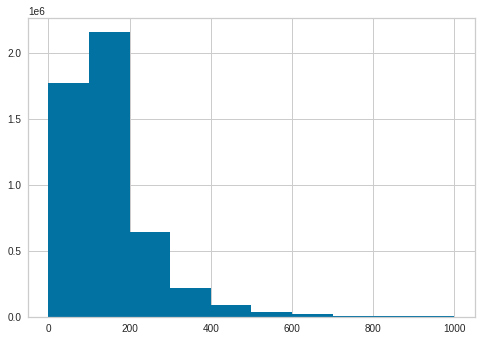

In [5]:
train_data[train_data['price_usd'] < 1000]['price_usd'].hist()

In [6]:
nan_filter = np.sum(train_data.isna()) > 0.75 * train_data.shape[0]
print('Dropping {0} columns: {1}'.format(len(train_data.columns[nan_filter]), train_data.columns[nan_filter]))
train_data = train_data.drop(columns=train_data.columns[nan_filter])
data_sample = train_data.sample(SAMPLE_SIZE, random_state=SEED)

Dropping 20 columns: Index(['visitor_hist_starrating', 'visitor_hist_adr_usd',
       'srch_query_affinity_score', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate_percent_diff',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate',
       'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate_percent_diff',
       'gross_bookings_usd'],
      dtype='object')


In [7]:
#massaging input for pre-visualization before model selection
sample_numeric = data_sample.select_dtypes('number')
sample_X = sample_numeric.loc[:, sample_numeric.columns != 'booking_bool']
sample_y = sample_numeric.booking_bool

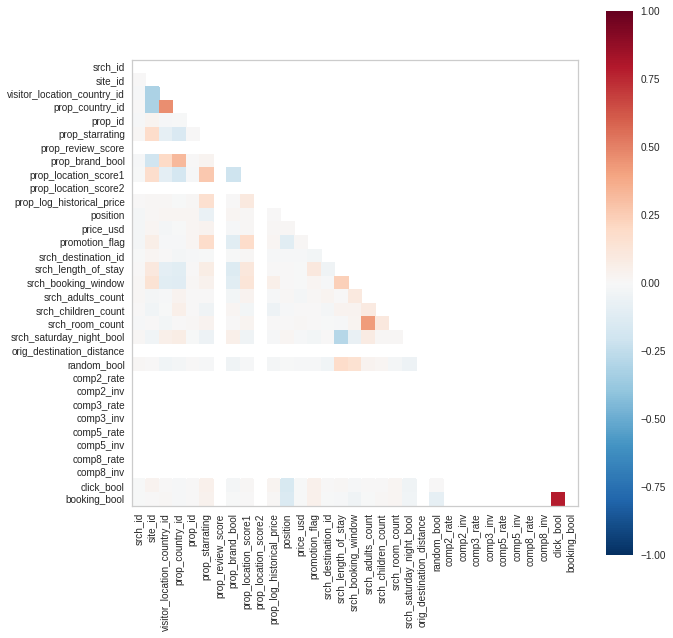

In [8]:
vis2d = features.Rank2D(algorithm='pearson', features=data_sample.select_dtypes('number').columns)
plt.figure(figsize=(10,10))
vis2d.fit_transform(np.matrix(data_sample.select_dtypes('number')));


We see that clicking has a very high positive correlation with booking. Other notabe positive correlations are between the search count of adults and the search room count, as well as visitor's country and property's country.

Text(0.5, 1.0, 'Shapiro-Wilk normality rank')

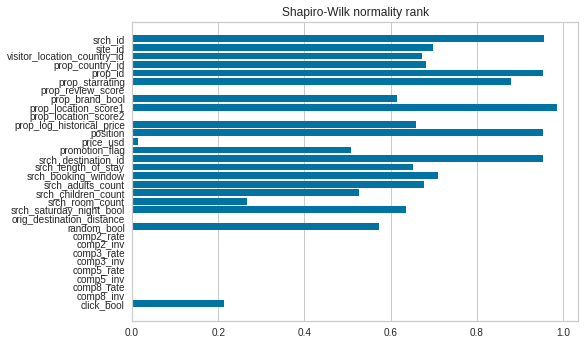

In [9]:
vis1d = features.rank1d(np.array(sample_X), features=sample_X.columns)
plt.title('Shapiro-Wilk normality rank')

We can see some features are very normally distributed, while others (review score, price) almost not at all.

Text(0.5, 1.0, 'Sample click rate (0 = no click, 1 = click)')

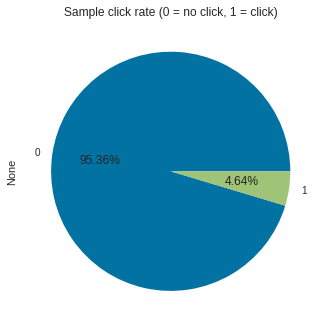

In [10]:
sample_X.groupby('click_bool').size().plot.pie(autopct='%1.2f%%');
plt.title('Sample click rate (0 = no click, 1 = click)')

Only 4 percent of searches result in a click-through.

0.2248468986642564 4.558650521938678 0.14610607248759921


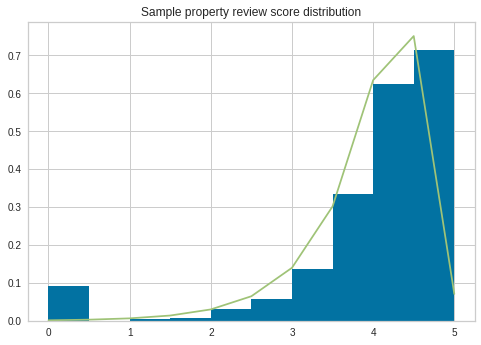

In [11]:
_, rscorebins, _ = plt.hist(np.abs(sample_X.prop_review_score), density=1);
plt.title('Sample property review score distribution');

rs_params = sp.stats.genlogistic.fit(sample_X[sample_X.prop_review_score > 0].prop_review_score) #(5, 0.6)
print(*rs_params)
norm_fit_line = sp.stats.genlogistic.pdf(rscorebins, *rs_params)

plt.plot(rscorebins, norm_fit_line)

Text(0.5, 1.0, 'Sample prices distribution above 2000 USD')

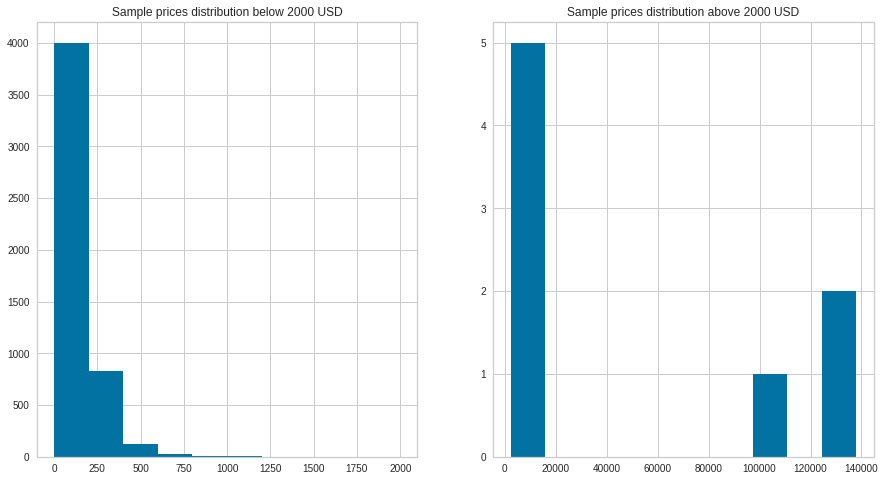

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))
ax[0].hist(sample_X[sample_X.price_usd < 2000].price_usd)
ax[0].set_title('Sample prices distribution below 2000 USD');
ax[1].hist(sample_X[sample_X.price_usd > 2000].price_usd)
ax[1].set_title('Sample prices distribution above 2000 USD')

Text(0.5, 1.0, 'Sample comparison with rates of competitor 2 (-1 = competitor has better price, 0 = no data, 1 = Expedia has better price)')

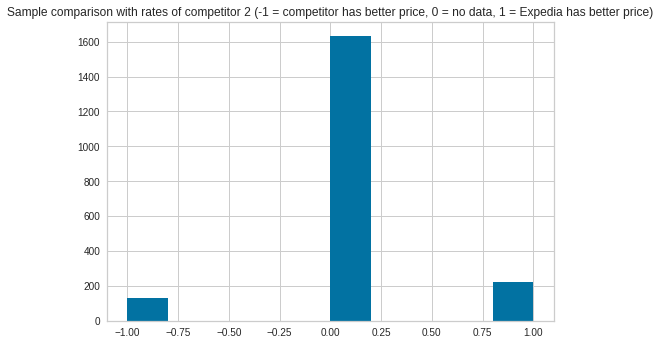

In [13]:
plt.hist(sample_X.comp2_rate)
plt.title('Sample comparison with rates of competitor 2 (-1 = competitor has better price, 0 = no data, 1 = Expedia has better price)')

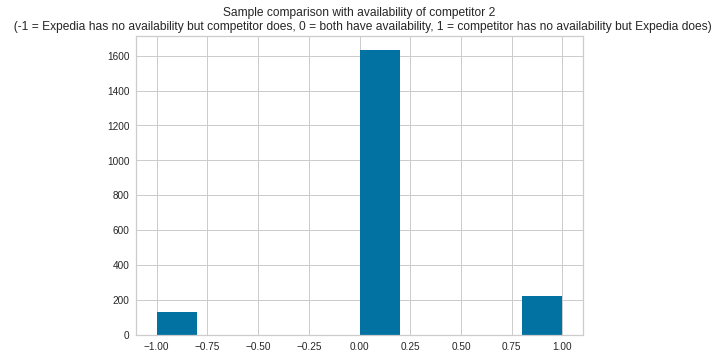

In [14]:
plt.hist(sample_X.comp2_rate)
plt.title('''Sample comparison with availability of competitor 2
  (-1 = Expedia has no availability but competitor does, 0 = both have availability, 1 = competitor has no availability but Expedia does)''');

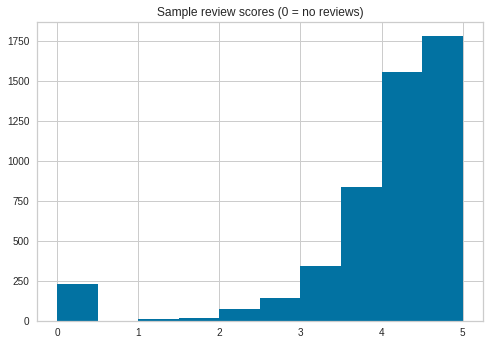

In [15]:
plt.hist(sample_X.prop_review_score)
plt.title('Sample review scores (0 = no reviews)');

##1.1 Dealing with NaNs in sample

In [16]:
print('Columns with missing data:\n', np.any(sample_X.isna(), axis=0))

Columns with missing data:
 srch_id                        False
site_id                        False
visitor_location_country_id    False
prop_country_id                False
prop_id                        False
prop_starrating                False
prop_review_score               True
prop_brand_bool                False
prop_location_score1           False
prop_location_score2            True
prop_log_historical_price      False
position                       False
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
orig_destination_distance       True
random_bool                    False
comp2_rate                      True
comp2_inv                       True
comp3_rate                      True
comp3_inv 

In [17]:
#How many entries for each column are NaN?

for c in sample_X.columns:
  print('NaNs in {0}: {1}'.format(c, sample_X[c].isna().sum()))

NaNs in srch_id: 0
NaNs in site_id: 0
NaNs in visitor_location_country_id: 0
NaNs in prop_country_id: 0
NaNs in prop_id: 0
NaNs in prop_starrating: 0
NaNs in prop_review_score: 9
NaNs in prop_brand_bool: 0
NaNs in prop_location_score1: 0
NaNs in prop_location_score2: 1080
NaNs in prop_log_historical_price: 0
NaNs in position: 0
NaNs in price_usd: 0
NaNs in promotion_flag: 0
NaNs in srch_destination_id: 0
NaNs in srch_length_of_stay: 0
NaNs in srch_booking_window: 0
NaNs in srch_adults_count: 0
NaNs in srch_children_count: 0
NaNs in srch_room_count: 0
NaNs in srch_saturday_night_bool: 0
NaNs in orig_destination_distance: 1631
NaNs in random_bool: 0
NaNs in comp2_rate: 3014
NaNs in comp2_inv: 2917
NaNs in comp3_rate: 3441
NaNs in comp3_inv: 3330
NaNs in comp5_rate: 2746
NaNs in comp5_inv: 2614
NaNs in comp8_rate: 3099
NaNs in comp8_inv: 3040
NaNs in click_bool: 0


In [19]:
print('Sample size (with NaN entries):', sample_X.shape)
print('Sample size after dropping all NaN-possessing entries:', sample_X.dropna().shape)

Sample size (with NaN entries): (5000, 32)
Sample size after dropping all NaN-possessing entries: (449, 32)


If we were to drop all entries with NaNs we'd lose around 90% of sample data.

In [20]:
print('Means of comparison rates in sample data:', sample_X.comp2_rate.mean(), 
      sample_X.comp3_rate.mean(), sample_X.comp5_rate.mean(), 
      sample_X.comp8_rate.mean())

Means of comparison rates in sample data: 0.045317220543806644 0.01860166773572803 0.013309671694764862 -0.06891109942135717


In [21]:
print('Means of comparative availability in sample data:', sample_X.comp2_inv.mean(), 
      sample_X.comp3_inv.mean(), sample_X.comp5_inv.mean(), 
      sample_X.comp8_inv.mean())

Means of comparative availability in sample data: 0.03888622179548728 0.05389221556886228 0.054065381391450125 0.010714285714285714


The comparative rates and comparative availability all oscillate around 0, so we can fill in the missing data with 0s instead of dropping rows with NaNs in these columns.

In [22]:
fill_cols = ['comp2_rate', 'comp2_inv', 'comp3_rate', 'comp3_inv', 'comp5_rate', 'comp5_inv', 'comp8_rate', 'comp8_inv']
sample_X_imputed = pd.DataFrame.copy(sample_X)
sample_X_imputed[fill_cols] = sample_X_imputed[fill_cols].fillna(0)

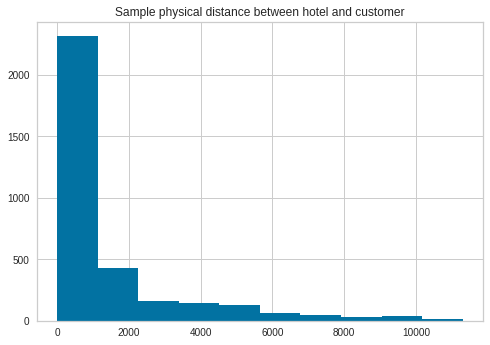

In [23]:
_, ddbins, _ = plt.hist(sample_X.orig_destination_distance)
plt.title('Sample physical distance between hotel and customer');

This appears to be an exponential distribution, so we fit an exponential.

Text(0.5, 1.0, 'Distance with fitted exponential distribution with parameters 0.05, 1357.38')

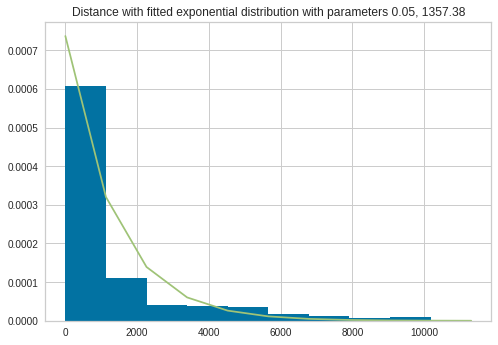

In [24]:
_, dd_bins, _ = plt.hist(sample_X.orig_destination_distance, density=1)
dd_params = sp.stats.expon.fit(sample_X.orig_destination_distance.dropna())
fit_dd_line = sp.stats.expon.pdf(dd_bins, *dd_params)
plt.plot(dd_bins, fit_dd_line)
plt.title('Distance with fitted exponential distribution with parameters {0}, {1}'.format(dd_params[0], round(dd_params[1], 2)))

In [25]:
dd_nan_count = sum(sample_X_imputed.orig_destination_distance.isna())
sample_X_imputed.orig_destination_distance = sample_X_imputed.orig_destination_distance.fillna(
    pd.Series(sp.stats.expon.rvs(*dd_params, dd_nan_count)))

#3 Recommender

In [26]:
target = train_data.pop('booking_bool')

In [27]:
pd.Categorical(train_data['comp2_rate'])

[0.0, NaN, 0.0, -1.0, 0.0, ..., NaN, NaN, NaN, NaN, NaN]
Length: 4958347
Categories (3, float64): [-1.0, 0.0, 1.0]